In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DS20201

Mounted at /content/drive
/content/drive/MyDrive/DS20201


In [2]:
pip install currencyconverter

     |████████████████████████████████| 522kB 15.6MB/s 
  Created wheel for currencyconverter: filename=CurrencyConverter-0.14.4-cp36-none-any.whl size=514210 sha256=d4a7f9f139854c0237396caa93e5077953b2567207de9d072b2b3efcfa4ff7fc
  Stored in directory: /root/.cache/pip/wheels/49/d3/77/bf96356a8f75ce70320a6bcb5c751ac65210c1c1647393ebcd
Successfully built currencyconverter


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import keras
from keras import backend
from currency_converter import CurrencyConverter
sns.set()

In [9]:
data = pd.read_csv('dataset/all_data.csv', sep=',')
data.head()

,title,release,certificate,runtime,genre,rating,metascore,summary,director,star,vote,gross,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,budget
0,Happiest Season,2020,PG-13,102.0,"Comedy, Drama, Romance",6.7,68.0,A holiday romantic comedy that captures the ra...,Clea DuVall,"Kristen Stewart,Mackenzie Davis,Mary Steenburg...",15262,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
1,The Christmas Chronicles: Part Two,2020,PG,112.0,"Adventure, Comedy, Family",6.1,51.0,"Kate Pierce, now a cynical teen, is unexpected...",Chris Columbus,"Kurt Russell,Goldie Hawn,Darby Camp,Julian Den...",11357,NaN,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2,Mulan,2020,PG-13,115.0,"Action, Adventure, Drama",5.5,66.0,A young Chinese maiden disguises herself as a ...,Niki Caro,"Yifei Liu,Donnie Yen,Li Gong,Jet Li",84189,NaN,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"$200,000,000"
3,Home Alone,1990,PG,103.0,"Comedy, Family",7.6,63.0,An eight-year-old troublemaker must protect hi...,Chris Columbus,"Macaulay Culkin,Joe Pesci,Daniel Stern,John Heard",466314,"285,761,243",0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"$18,000,000"
4,Tenet,2020,PG-13,150.0,"Action, Sci-Fi",7.6,69.0,"Armed with only one word, Tenet, and fighting ...",Christopher Nolan,"John David Washington,Robert Pattinson,Elizabe...",196286,"53,800,000",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"$205,000,000"


## **Xử lý dữ liệu**

In [10]:
gross = data.gross
for i in range(len(gross)):
  if not pd.isna(gross[i]):
    gross[i] = float(gross[i].replace(',',''))

c = CurrencyConverter()
budget = data.budget
for i in range(len(budget)):
  if not pd.isna(budget[i]):
    s = ''
    d = 'USD'
    for j in budget[i]:
      if j.isalpha():
        s += j
    n = re.findall(r'\d+', budget[i])
    n = ''.join(n)
    try:
      budget[i] = float(c.convert(int(n), s, d))
    except:
      budget[i] = float(n)
  
data = data[['title', 'certificate', 'director', 'star', 'genre', 'release', 'runtime', 'metascore', 'vote',
             'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
 					  'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 
 					  'Musical', 'Mystery', 'News','Reality-TV',	'Romance', 'Sci-Fi', 'Sport', 'Talk-Show',	 
 					  'Thriller', 'War', 'Western','gross', 'budget', 'rating']]
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title,certificate,director,star,genre,release,runtime,metascore,vote,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,gross,budget,rating
0,Happiest Season,PG-13,Clea DuVall,"Kristen Stewart,Mackenzie Davis,Mary Steenburg...","Comedy, Drama, Romance",2020,102.0,68.0,15262,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,6.7
1,The Christmas Chronicles: Part Two,PG,Chris Columbus,"Kurt Russell,Goldie Hawn,Darby Camp,Julian Den...","Adventure, Comedy, Family",2020,112.0,51.0,11357,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,6.1
2,Mulan,PG-13,Niki Caro,"Yifei Liu,Donnie Yen,Li Gong,Jet Li","Action, Adventure, Drama",2020,115.0,66.0,84189,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,2e+08,5.5
3,Home Alone,PG,Chris Columbus,"Macaulay Culkin,Joe Pesci,Daniel Stern,John Heard","Comedy, Family",1990,103.0,63.0,466314,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.85761e+08,1.8e+07,7.6
4,Tenet,PG-13,Christopher Nolan,"John David Washington,Robert Pattinson,Elizabe...","Action, Sci-Fi",2020,150.0,69.0,196286,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.38e+07,2.05e+08,7.6


In [18]:
data.to_csv('dataset/processed_data_nlc.csv', index=False)

In [ ]:
print(data.release.min())

1911


1. Định dạng lại dữ liệu trong hai cột gross và budget: loại bỏ ký tự thừa, chuyển từ string thành float

2. Thay thế các giá trị missing bằng giá trị trung bình

3. Chuẩn hóa giá trị các biến numerical về khoảng [-1, 1]

4. Chuyển đổi đơn vị tiền tệ sang một định dạng chung USD

5. Chuyển thể loại phim sang one-hot encoding (26 thể loại)

## **Phân tích dữ liệu**

In [ ]:
len(data)

30794

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30794 entries, 0 to 30793
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        30794 non-null  object 
 1   certificate  24818 non-null  object 
 2   director     30794 non-null  object 
 3   star         30786 non-null  object 
 4   genre        30794 non-null  object 
 5   release      30794 non-null  int64  
 6   runtime      30773 non-null  float64
 7   metascore    12056 non-null  float64
 8   vote         30794 non-null  int64  
 9   Action       30794 non-null  int64  
 10  Adventure    30794 non-null  int64  
 11  Animation    30794 non-null  int64  
 12  Biography    30794 non-null  int64  
 13  Comedy       30794 non-null  int64  
 14  Crime        30794 non-null  int64  
 15  Documentary  30794 non-null  int64  
 16  Drama        30794 non-null  int64  
 17  Family       30794 non-null  int64  
 18  Fantasy      30794 non-null  int64  
 19  Film

In [ ]:
data.describe()

,release,runtime,metascore,vote,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,rating
count,30794.000000,30773.000000,12056.000000,3.079400e+04,30794.000000,30794.000000,30794.000000,30794.000000,30794.000000,30794.000000,30794.0,30794.000000,30794.000000,30794.000000,30794.000000,30794.0,30794.000000,30794.000000,30794.000000,30794.000000,30794.000000,30794.0,30794.0,30794.000000,30794.000000,30794.000000,30794.0,30794.000000,30794.000000,30794.000000,30794.000000
mean,1996.300935,105.256816,56.511778,2.648860e+04,0.193090,0.117685,0.033416,0.045821,0.363350,0.167825,0.0,0.569981,0.043645,0.058973,0.010229,0.0,0.034422,0.130350,0.025914,0.020361,0.078262,0.0,0.0,0.186627,0.056017,0.016757,0.0,0.154933,0.027765,0.015133,6.331522
std,22.056923,22.279307,17.867484,8.844730e+04,0.394729,0.322240,0.179722,0.209099,0.480972,0.373717,0.0,0.495086,0.204307,0.235577,0.100623,0.0,0.182314,0.336694,0.158882,0.141234,0.268588,0.0,0.0,0.389618,0.229959,0.128360,0.0,0.361846,0.164302,0.122083,1.122573
min,1911.000000,25.000000,1.000000,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
25%,1986.000000,91.000000,44.000000,1.713000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,5.700000
50%,2004.000000,100.000000,57.000000,3.560000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,6.500000
75%,2013.000000,114.000000,70.000000,1.240325e+04,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,7.100000
max,2020.000000,729.000000,100.000000,2.317527e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,9.400000


In [ ]:
data.isna().sum()

title              0
certificate     5976
director           0
star               8
genre              0
release            0
runtime           21
metascore      18738
vote               0
Action             0
Adventure          0
Animation          0
Biography          0
Comedy             0
Crime              0
Documentary        0
Drama              0
Family             0
Fantasy            0
Film-Noir          0
Game-Show          0
History            0
Horror             0
Music              0
Musical            0
Mystery            0
News               0
Reality-TV         0
Romance            0
Sci-Fi             0
Sport              0
Talk-Show          0
Thriller           0
War                0
Western            0
gross          18491
budget         17079
rating             0
dtype: int64

- Dữ liệu có 30794 bản ghi
- Gồm có 13 trường dữ liệu: title, release, certificate, runtime, genre, metascore, summary, director, star, vote, gross, budget, rating
- Các cột có giá trị NULL: certificate(5976), gross(18491), budget(17079), metascore(18738), summary(60), runtime(21)
  

**1. Rating**

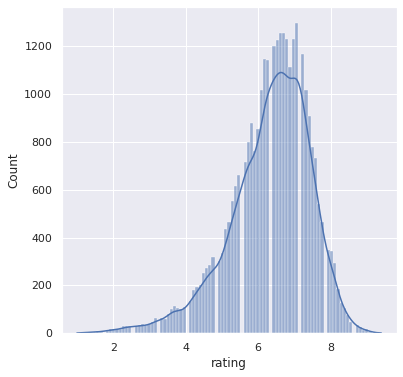

In [ ]:
plt.figure(figsize=(6,6))
sns.histplot(data.rating, kde=True)
#data.rating.plot.hist(figsize=(6,6))

Đa phần phim được đánh giá trong khoảng từ 5 đến 8

**2. Runtime**




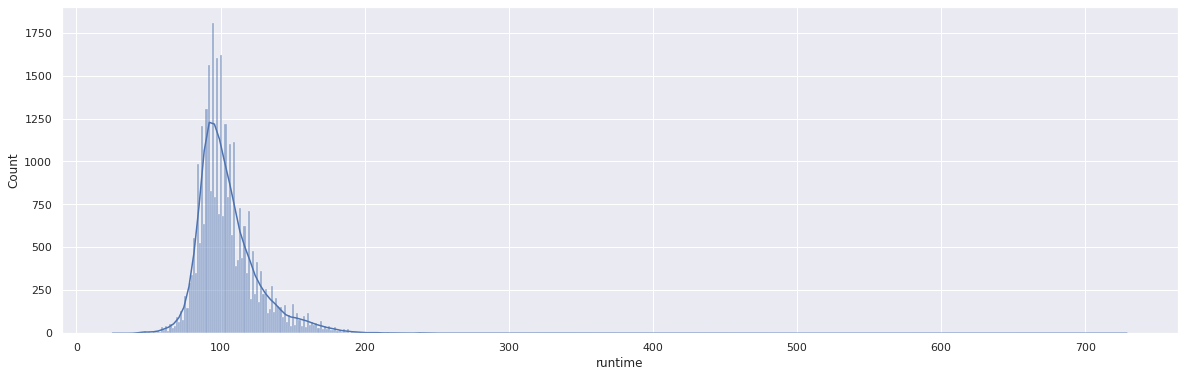

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(data.runtime, kde=True)

thời lượng phim tập trung trong khoảng 100 phút

**3. Year**

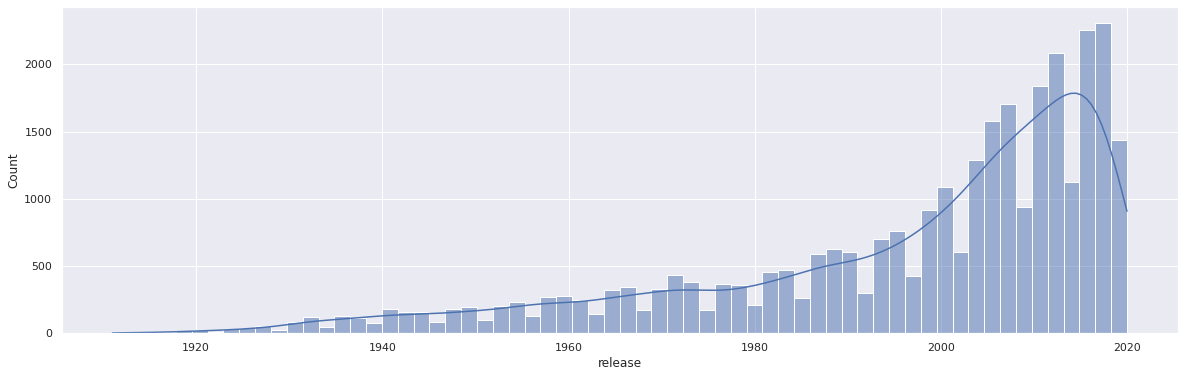

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(data.release, kde=True)

số lượng phim tăng nhanh kể từ sau năm 1950 -> sau chiến tranh thế giới thứ 2 -> sự bất ổn chính trị và kinh tế ảnh hưởng đến sản xuất phim

**4. Vote**

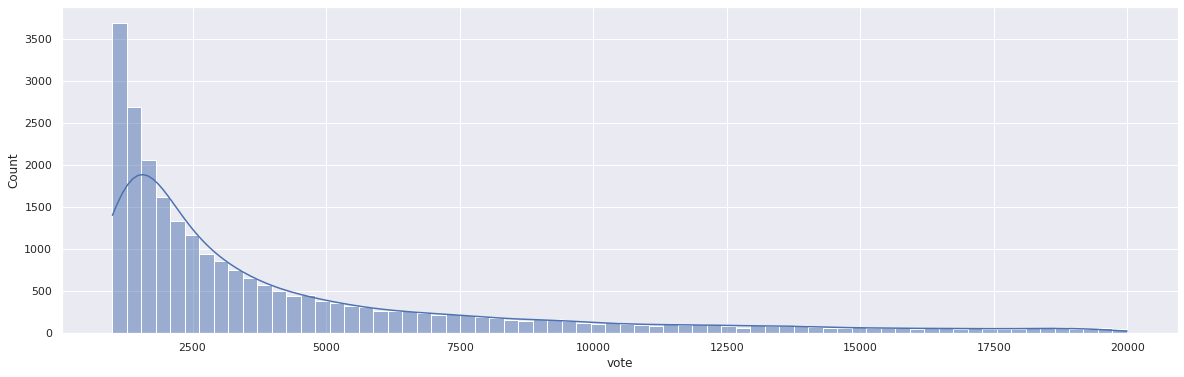

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(data[data.vote<20000].vote, kde=True)

right skewed -> người xem ít vote cho phim

**5. Gross**

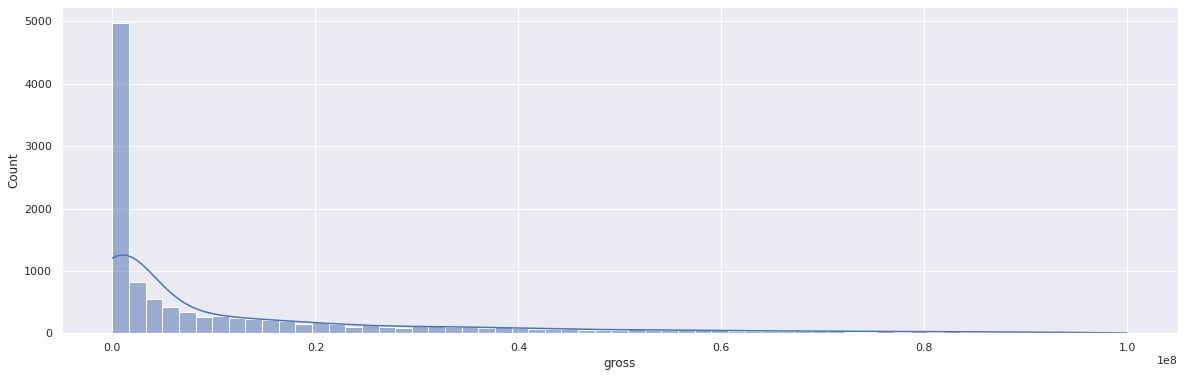

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(data[(data.gross.notnull()) & (data.gross < 100000000)].gross.astype('float64') , kde=True)

**6. Budget**

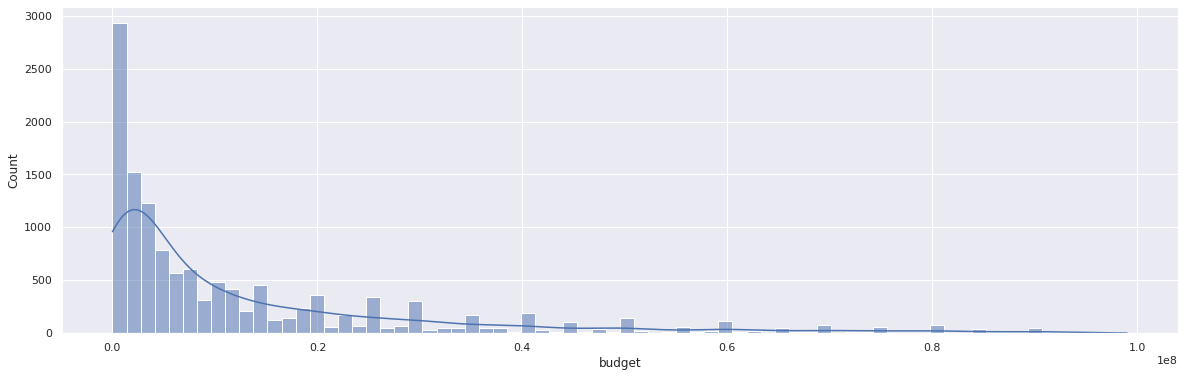

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(data[(data.budget.notnull()) & (data.budget < 100000000)].budget.astype('float64') , kde=True)

Cả gross và budget đều tập trung trong khoảng 0-20 triệu đô, đồng thời hai biểu đồ có sự tương đồng cao -> sẽ đánh giá ở phần sau



**7. Genre**

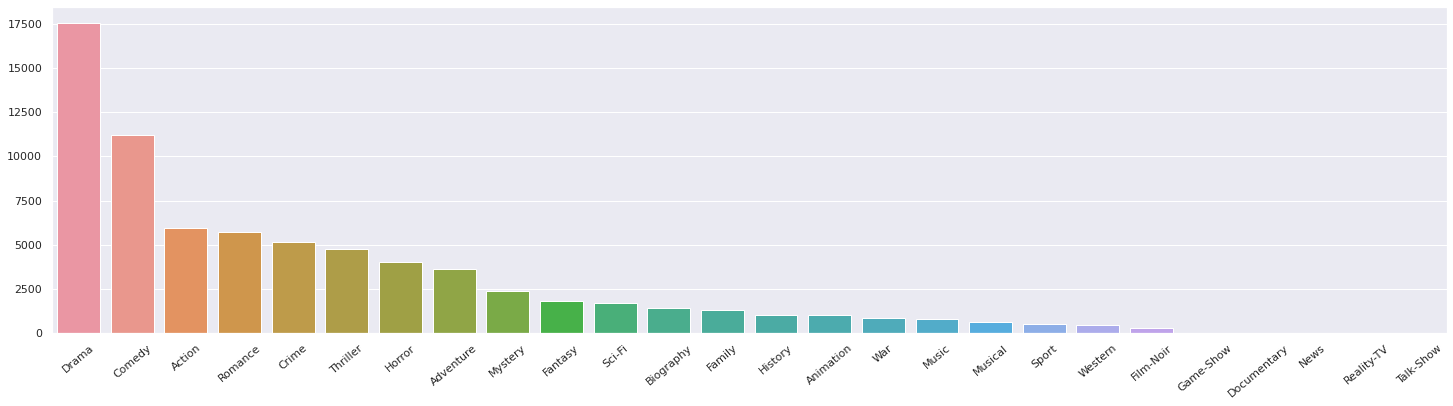

In [ ]:
plt.figure(figsize=(25, 6))
a = data[['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
 					  'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 
 					  'Musical', 'Mystery', 'News','Reality-TV',	'Romance', 'Sci-Fi', 'Sport', 'Talk-Show',	 
 					  'Thriller', 'War', 'Western']].sum().sort_values(ascending=False)
plt.xticks(rotation=40) 
sns.barplot(x=a.index, y=a.values)

Đa phần phim thuộc thể loại drama và comedy

**8. Metascore**

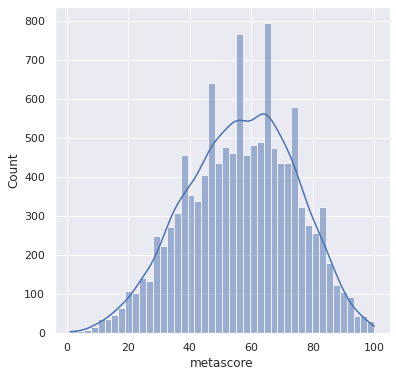

In [ ]:
plt.figure(figsize=(6,6))
sns.histplot(data.metascore, kde=True)

Điểm metascore chủ yếu năm trong khoảng 50-70

**9. Sử dụng biến phụ thuộc là rating -> cần tìm mối quan hệ giữa các biến độc lập với rating**

9.1. Độ tương quan giữa các cột

9.1.1. Giữa các biến Numerical với rating

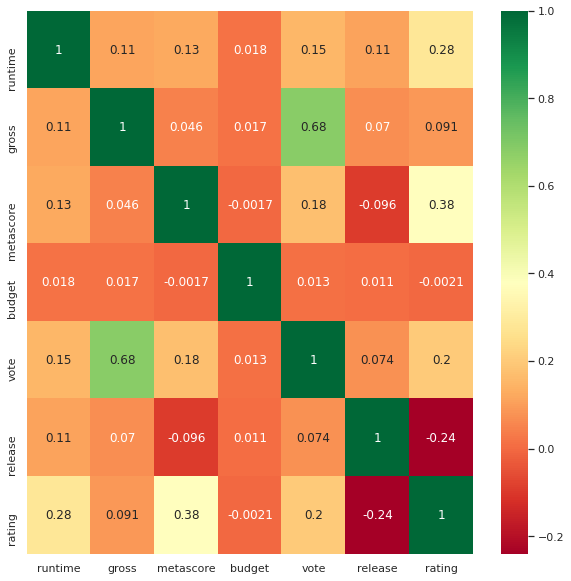

In [ ]:
# runtime, gross, metascore, budget, vote, rating
plt.figure(figsize=(10,10))
df = data[['runtime', 'gross', 'metascore', 'budget', 'vote', 'release','rating']]
df = df.fillna(df.median())
sns.heatmap(df[df.columns].corr(), annot=True, cmap="RdYlGn")

rating có mối tương quan đáng kể với runtime, metascore, vote (tương quan dương) và release (tương quan âm)

9.1.2. Giữa các biến Categorical với rating

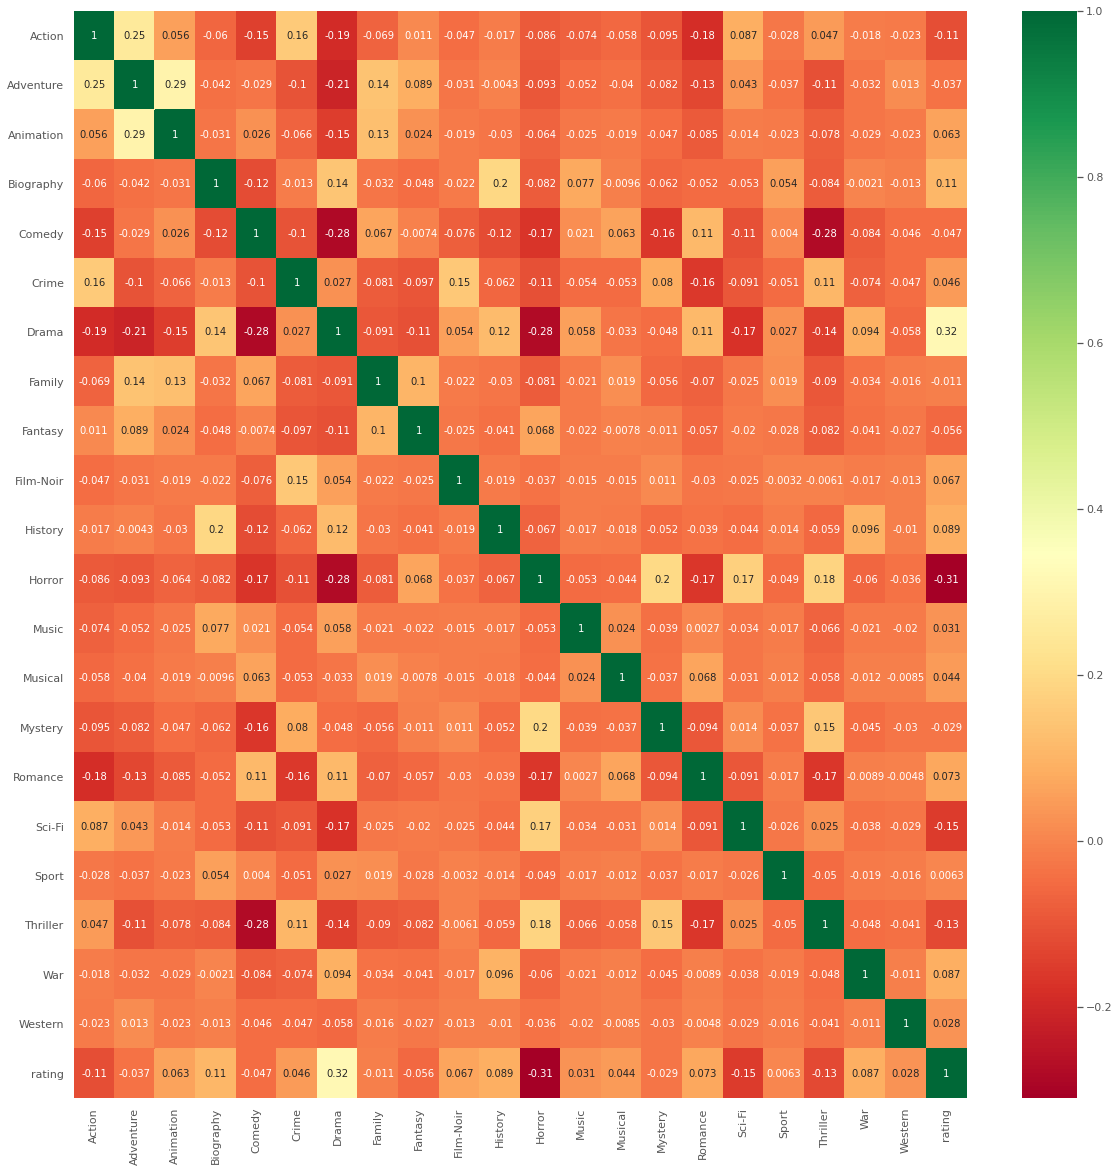

In [ ]:
# các thể loại phim và rating
plt.figure(figsize=(20, 20))
df = data[['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
					  'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 
					  'Musical', 'Mystery',	'Romance', 'Sci-Fi', 'Sport',	 
					  'Thriller', 'War', 'Western', 'rating']]
img = sns.heatmap(df[df.columns].corr(), annot=True, cmap="RdYlGn")
img.figure.savefig("/content/drive/MyDrive/DS20201/dataset/c.png")

rating có mối tương quan đáng kể với Drama (tương quan dương) và Horror (tương quan âm)

In [14]:
data_ = data.fillna(data.median())
run_max = data.runtime.max()
run_min = data.runtime.min()
run_mean = data.runtime.mean()

meta_max = data.metascore.max()
meta_min = data.metascore.min()
meta_mean = data.metascore.mean()

vote_max = data.vote.max()
vote_min = data.vote.min()
vote_mean = data.vote.mean()

# gross_max = data.gross.max()
# gross_min = data.gross.min()
# gross_mean = data.gross.mean()

# df.runtime = (df.runtime-run_min)/(run_max-run_min)
# df.metascore = (df.metascore-meta_min)/(meta_max-meta_min)
# df.vote = (df.vote-vote_min)/(vote_max-vote_min)
# df.gross = (df.gross-gross_min)/(gross_max-gross_min)

data_.runtime = 2*(data_.runtime-run_mean)/(run_max-run_min)
data_.metascore = 2*(data_.metascore-meta_mean)/(meta_max-meta_min)
data_.vote = 2*(data_.vote-vote_mean)/(vote_max-vote_min)
# data_.gross = 2*(data_.gross-gross_mean)/(gross_max-gross_min)

data_.release = data.release - 1920
data_ = np.asarray(data_)


9.2. Vote vs Rating

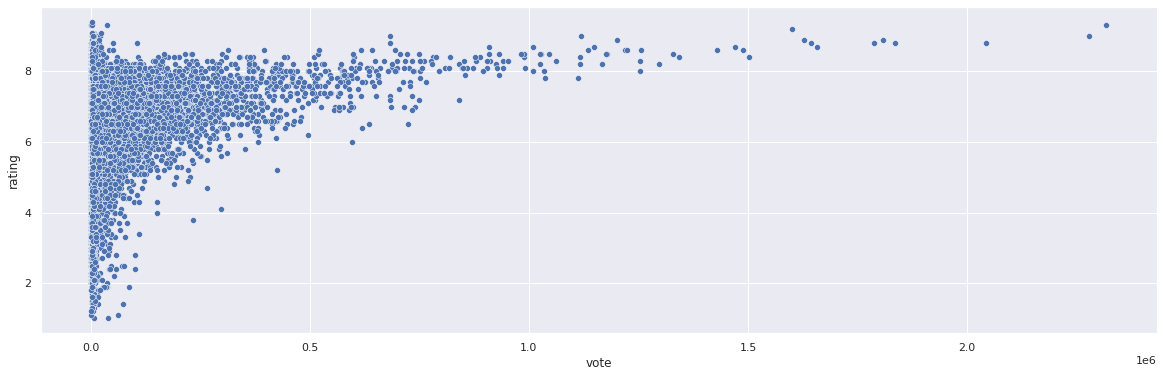

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x=data.vote, y= data.rating)

Độ tương quan được thể hiện rõ: càng nhiều vote, rating càng cao, nhưng hầu hết những bộ phim không được nhiều người vote, rating có phương sai lớn

9.3. Metascore vs Rating

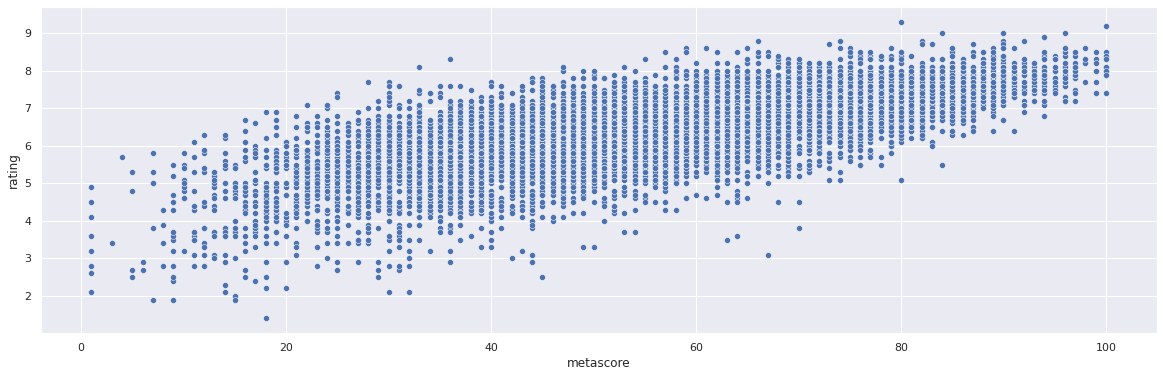

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x=data.metascore, y= data.rating)

Metascore và rating có độ tương đồng lớn, metascore càng cao, rating càng cao

9.4. Gross vs Rating

<Figure size 1080x1080 with 0 Axes>

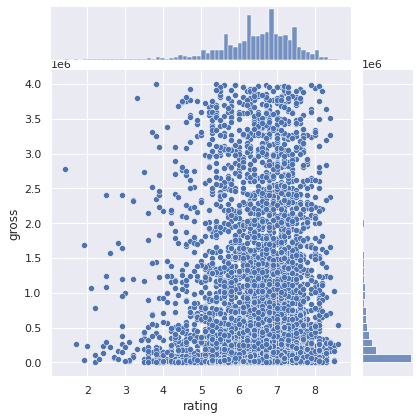

In [ ]:
plt.figure(figsize=(15,15))
a = data[data.gross<4000000][['rating', 'gross']]
sns.jointplot(x=a.rating, y=a.gross)

Không có quan hệ tuyến tính giữa gross và rating -> do đó rating cao không tương quan với doanh thu của phim



9.5. Budget vs Rating

<Figure size 1080x1080 with 0 Axes>

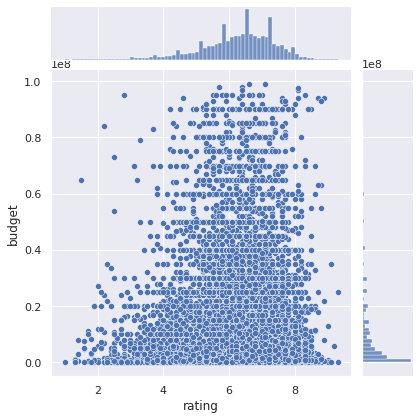

In [ ]:
plt.figure(figsize=(15,15))
a = data[data.budget<100000000][['rating', 'budget']]
sns.jointplot(x=a.rating, y=a.budget)

Không có quan hệ tuyến tính giữa budget và rating -> do đó kinh phí cao không tương quan với rating của phim

Cả gross và budget đều không có mối quan hệ tuyến tính với rating, đông thời hai trường dữ liệu này có nhiều giá trị mising, gross và budget còn phụ thuộc vào nhiều yếu tố khách quan khác như lạm phát, khấu hao, ... -> không dùng hai trường này trong mô hình

9.6. Runtime vs Rating

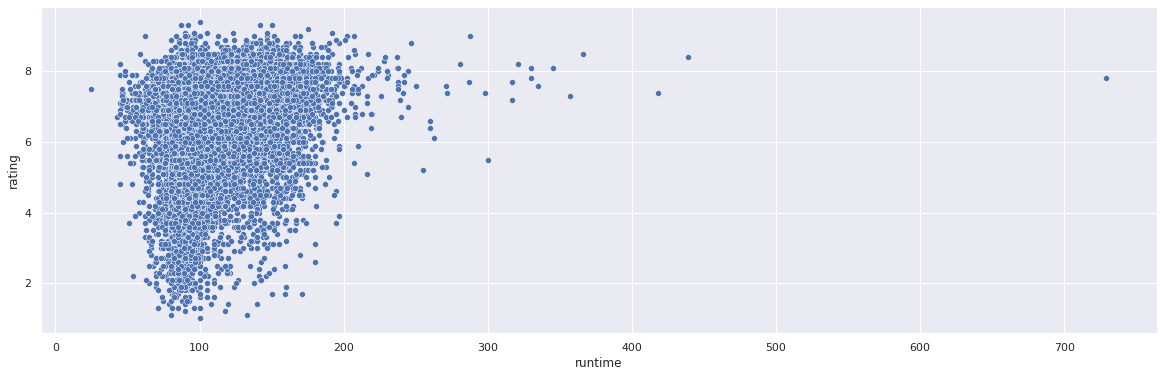

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x=data.runtime, y= data.rating)

Ở đây cũng chỉ ra thời lượng phim dài tương đồng với rating cao, nhưng chỉ có một số rất ít phim có thời lượng lớn

9.7. Release vs Rating

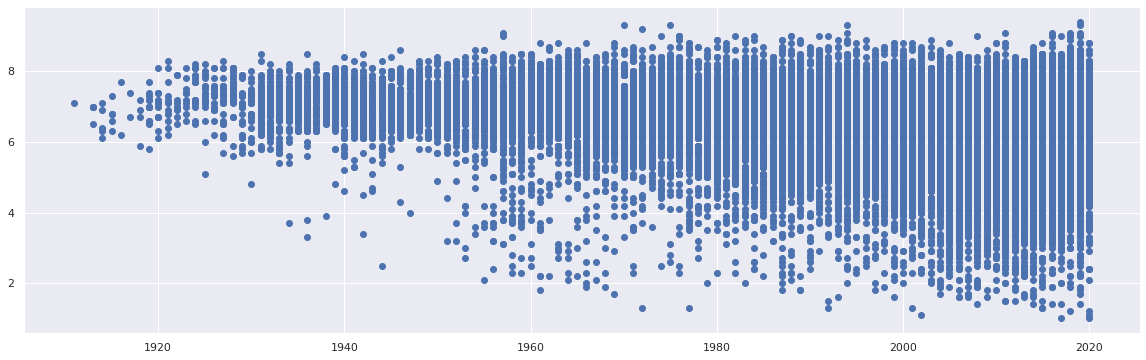

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(data.release, data.rating)

rating và year có tương quan âm, do càng gần đây, phương sai của rating càng lớn -> có nhiều phim bị đánh giá tiêu cực 

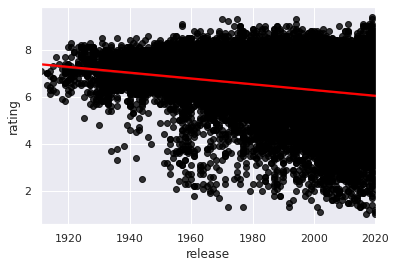

In [ ]:
sns.regplot(x=data.release, y=data.rating, scatter_kws={"color": "black"}, line_kws={"color": "red"})

# **Xây dựng mô hình**

Từ những phân tích trên, ta chọn các biến sau cho mô hình: runtime, metascore, vote, release, drama và horror

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30794 entries, 0 to 30793
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        30794 non-null  object 
 1   certificate  24818 non-null  object 
 2   director     30794 non-null  object 
 3   star         30786 non-null  object 
 4   genre        30794 non-null  object 
 5   release      30794 non-null  int64  
 6   runtime      30773 non-null  float64
 7   metascore    12056 non-null  float64
 8   vote         30794 non-null  int64  
 9   Action       30794 non-null  int64  
 10  Adventure    30794 non-null  int64  
 11  Animation    30794 non-null  int64  
 12  Biography    30794 non-null  int64  
 13  Comedy       30794 non-null  int64  
 14  Crime        30794 non-null  int64  
 15  Documentary  30794 non-null  int64  
 16  Drama        30794 non-null  int64  
 17  Family       30794 non-null  int64  
 18  Fantasy      30794 non-null  int64  
 19  Film

In [13]:
data_[:, 5]

NameError: ignored

**1. Hồi quy tuyến tính**

In [ ]:
train_data, test_data = train_test_split(data_, test_size=0.2, random_state=1)
train_data, val_data = train_test_split(train_data, test_size= 0.1, random_state=1)

In [ ]:
X_train, y_train = train_data[:, [5,6,7,8,16,22]].astype(np.float32), train_data[:,-1].astype(np.float32)
X_test, y_test = test_data[:, [5,6,7,8,16,22]].astype(np.float32), test_data[:,-1].astype(np.float32)
X_val, y_val = val_data[:, [5,6,7,8,16,22]].astype(np.float32), val_data[:, -1].astype(np.float32)

In [ ]:
LR = LinearRegression()
LR.fit(X_train, y_train)
w = LR.coef_
b = LR.intercept_
print('W: ', w)
print('b: ', b)
print('Score: ', LR.score(X_train, y_train)) # Score Coefficient of determination -->  càng lớn càng tốt

# RMSE
y_pred = LR.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Linear Regression RMSE: ', rmse)

W:  [-0.01225221  3.1058822   1.2705495   2.2072914   0.42404506 -0.6328518 ]
b:  7.1024046
Score:  0.35447219630196364
Linear Regression RMSE:  0.8993065


In [ ]:
ridge = Ridge(alpha=100.0)
ridge.fit(X_train, y_train)
w = ridge.coef_
b = ridge.intercept_
print('W: ', w)
print('b: ', b)
print('Score: ', ridge.score(X_train, y_train))


y_pred = ridge.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Ridge: ', rmse)

W:  [-0.01153586  1.5075117   1.2607708   1.3476073   0.45122796 -0.6653948 ]
b:  7.0366635
Score:  0.34169602006608946
Ridge:  0.9063553


In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
w = ridge.coef_
b = ridge.intercept_
print('W: ', w)
print('b: ', b)
print('Score: ', lasso.score(X_train, y_train))

y_pred = lasso.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Lasso: ', rmse)

W:  [-0.01153586  1.5075117   1.2607708   1.3476073   0.45122796 -0.6653948 ]
b:  7.0366635
Score:  0.12809560873663917
Lasso:  1.0481254


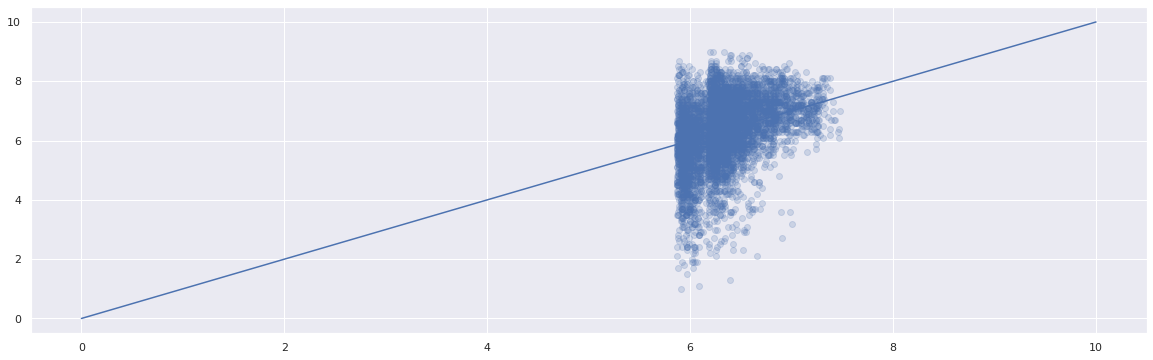

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 10), np.linspace(0, 10))
plt.scatter(y_pred, y_test, alpha=0.2)

**2. Neural network**

In [ ]:
X_train, y_train = train_data[:, 5:35].astype(np.float32), train_data[:,-1].astype(np.float32)
X_test, y_test = test_data[:, 5:35].astype(np.float32), test_data[:,-1].astype(np.float32)
X_val, y_val = val_data[:, 5:35].astype(np.float32), val_data[:, -1].astype(np.float32)

In [ ]:
model = Sequential()
model.add(Dense(100, input_shape=(30,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               3100      
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)               

In [ ]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=rmse,
              optimizer=opt,
              metrics=[rmse])

Epoch 1/100
693/693 [==============================] - 3s 3ms/step - loss: 2.0749 - rmse: 2.0749 - val_loss: 3.5792 - val_rmse: 3.5792

Epoch 00001: val_rmse improved from inf to 3.57918, saving model to model_Proj.hdf5
Epoch 2/100
693/693 [==============================] - 2s 3ms/step - loss: 1.2423 - rmse: 1.2423 - val_loss: 2.6262 - val_rmse: 2.6262

Epoch 00002: val_rmse improved from 3.57918 to 2.62617, saving model to model_Proj.hdf5
Epoch 3/100
693/693 [==============================] - 2s 3ms/step - loss: 1.1096 - rmse: 1.1096 - val_loss: 1.8161 - val_rmse: 1.8161

Epoch 00003: val_rmse improved from 2.62617 to 1.81615, saving model to model_Proj.hdf5
Epoch 4/100
693/693 [==============================] - 2s 3ms/step - loss: 1.0432 - rmse: 1.0432 - val_loss: 1.7448 - val_rmse: 1.7448

Epoch 00004: val_rmse improved from 1.81615 to 1.74479, saving model to model_Proj.hdf5
Epoch 5/100
693/693 [==============================] - 2s 3ms/step - loss: 1.0001 - rmse: 1.0001 - val_loss:

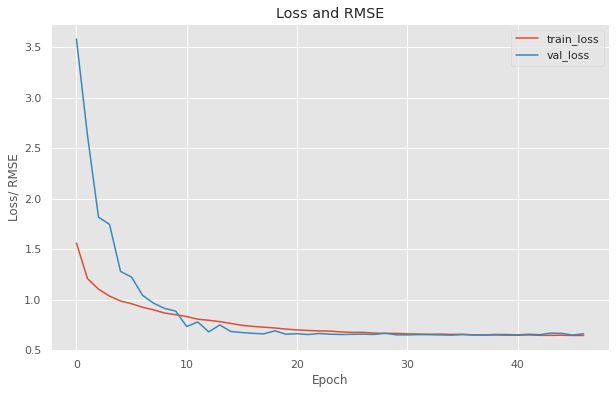

In [ ]:
epoch = 100
batch_size = 32

filepath="model_Proj.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_rmse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

H = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epoch, verbose=1, callbacks=callbacks_list)

N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure(figsize=(10, 6))
plt.plot(N, H.history["loss"])
plt.plot(N, H.history["val_loss"])
plt.title("Loss and RMSE")
plt.xlabel("Epoch")
plt.ylabel("Loss/ RMSE")
plt.legend(["train_loss","val_loss"], loc="upper right")
plt.show()

In [19]:
model.evaluate(X_test, y_test)

NameError: ignored

In [ ]:
#model = load_model('model_Proj.hdf5', compile=False)
y_pred = model.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

ValueError: ignored

In [ ]:
LR = LinearRegression()
LR.fit(X_train, y_train)
w = LR.coef_
b = LR.intercept_
print('W: ', w)
print('b: ', b)
print('Score: ', LR.score(X_train, y_train)) # Score Coefficient of determination -->  càng lớn càng tốt

# RMSE
y_pred = LR.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Linear Regression RMSE: ', rmse)

# **Nhận xét**

Với mô hình hồi quy tuyến tính, trung bình mỗi rating bị dự đoán sai lệch khoảng 0.8993065

Với mô hình mạng neural, trung bình mỗi rating bị dự đoán sai lệch khoảng 0.8668821